## 1.Environment Setup & Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from surprise import KNNWithMeans, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split, cross_validate, GridSearchCV, LeaveOneOut
from sklearn.metrics import confusion_matrix, classification_report, r2_score, precision_score, recall_score, f1_score
from collections import defaultdict, Counter

# Define path
data_path = '../datasets/student_grade.csv'



In [ ]:
df = pd.read_csv(data_path, low_memory=False)
df

## 2.Data Loading & Preprocessing

In [2]:
# === 2.1 Load Data ===
df = pd.read_csv(data_path, low_memory=False)

# === 2.2 Transform Data (Wide to Long) ===
id_vars = ['student_id']
df_long = pd.melt(df, id_vars=id_vars, var_name='course', value_name='grade')

# === 2.3 Clean Data ===
# Convert grade to numeric and remove invalid/empty grades
df_long['grade'] = pd.to_numeric(df_long['grade'], errors='coerce')
df_long_cleaned = df_long[(df_long['grade'] > 0.0) & (df_long['grade'].notna())].copy()

# === 2.4 Filter for 'INT' Courses Only ===
# This ensures the model only learns from INT courses
df_long_filtered = df_long_cleaned[df_long_cleaned['course'].astype(str).str.startswith('INT')].copy()

print(f"--- Data Preparation Complete ---")
print(f"Total records after cleaning: {len(df_long_cleaned)}")
print(f"Filtered to INT courses only: {len(df_long_filtered)}")
display(df_long_filtered)


--- Data Preparation Complete ---
Total records after cleaning: 43104
Filtered to INT courses only: 17468


,student_id,course,grade
25871,A246,INT102 WEB TECHNOLOGY,1.5
27143,A632,INT102 WEB TECHNOLOGY,3.0
27144,A086,INT102 WEB TECHNOLOGY,4.0
27145,A662,INT102 WEB TECHNOLOGY,4.0
27146,A066,INT102 WEB TECHNOLOGY,2.5
...,...,...,...
592988,A385,INT491 SPECIAL TOPICS I : APPLIED COMPUTER VISION,3.5
592990,A424,INT491 SPECIAL TOPICS I : APPLIED COMPUTER VISION,2.5
593003,A111,INT491 SPECIAL TOPICS I : APPLIED COMPUTER VISION,2.5
593005,A627,INT491 SPECIAL TOPICS I : APPLIED COMPUTER VISION,2.5


## 3.Split Data to train and test set

In [3]:
# === 3.1 Load Data into Surprise Dataset ===
# Define rating scale (assuming grades are 1.0 to 4.0)
reader = Reader(rating_scale=(1, 4))
data = Dataset.load_from_df(df_long_filtered[['student_id', 'course', 'grade']], reader)

# === 3.2 Split Data ===
trainset, testset = train_test_split(data, test_size=0.30, random_state=42)

## 4.Model Training (KNNWithMeans)


In [4]:
# === 3.3 Train the Model ===
print("--- Training KNN Model (User - User) with Means ---")

sim_user = {
    "name": "pearson",      # เหมาะกับ KNNWithMeans
    "user_based": True
}

algo_user = KNNWithMeans(
    k=30,
    min_k=3,
    sim_options=sim_user
)

algo_user.fit(trainset)
print("Training KNN Model (User - User) complete.")
print("-----------------------------------------------------")

print("--- Training KNN Model (Item - Item) with Means ---")

sim_item = {
    "name": "pearson",      
    "user_based": False
}

algo_item = KNNWithMeans(
    k=40,
    min_k=3,
    sim_options=sim_item
)

algo_item.fit(trainset)
print("Training KNN Model (Item - Item) complete.")



--- Training KNN Model (User - User) with Means ---
Computing the pearson similarity matrix...
Done computing similarity matrix.
Training KNN Model (User - User) complete.
-----------------------------------------------------
--- Training KNN Model (Item - Item) with Means ---
Computing the pearson similarity matrix...
Done computing similarity matrix.
Training KNN Model (Item - Item) complete.


In [ ]:
def recommend_for_user(algo, user_id, n=5):
    items = trainset.all_items()
    items_raw = [trainset.to_raw_iid(i) for i in items]

    predictions = [
        (iid, algo.predict(user_id, iid).est)
        for iid in items_raw
    ]

    predictions.sort(key=lambda x: x[1], reverse=True)
    return predictions[:n]

In [ ]:
def similar_items(algo, item_raw_id, k=5):
    inner = algo.trainset.to_inner_iid(item_raw_id)
    neighbors = algo.get_neighbors(inner, k=k)
    raw_ids = [algo.trainset.to_raw_iid(i) for i in neighbors]
    return raw_ids

In [ ]:
recommend_for_user(algo_user, "A246", n=10) # แนะนำวิชาให้ student_id = A246

In [ ]:
similar_items(algo_item, "INT102 WEB TECHNOLOGY") # วิชาที่คล้ายกัน

## 5.Test and evaluate model

In [5]:
# Predict on testset
pred_user = algo_user.test(testset)
pred_item = algo_item.test(testset)

# Evaluate
print("=== USER–USER KNN PERFORMANCE ===")
accuracy.rmse(pred_user)
accuracy.mae(pred_user)

print("\n=== ITEM–ITEM KNN PERFORMANCE ===")
accuracy.rmse(pred_item)
accuracy.mae(pred_item)

=== USER–USER KNN PERFORMANCE ===
RMSE: 0.5832
MAE:  0.4578

=== ITEM–ITEM KNN PERFORMANCE ===
RMSE: 0.5959
MAE:  0.4691


0.46911142243023796

In [6]:
loo = LeaveOneOut()
for trainset, testset in loo.split(data):
    algo_user.fit(trainset)
    preds = algo_user.test(testset)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.


In [7]:
df = pd.DataFrame(data.raw_ratings, columns=['uid','iid','rating','timestamp'])

user_counts = df['uid'].value_counts()
item_counts = df['iid'].value_counts()


print("Original dataset size:", len(df))
print("Unique users:", df['uid'].nunique())
print("Unique items:", df['iid'].nunique())

user_cnt = df['uid'].value_counts()
item_cnt = df['iid'].value_counts()

df_filtered = df[
    (df['uid'].isin(user_cnt[user_cnt >= 3].index)) &
    (df['iid'].isin(item_cnt[item_cnt >= 5].index))
]

print("Filtered dataset size:", len(df_filtered))
print("Unique users:", df_filtered['uid'].nunique())
print("Unique items:", df_filtered['iid'].nunique())

reader = Reader(rating_scale=(1, 5))
data_filtered = Dataset.load_from_df(
    df_filtered[['uid','iid','rating']],
    reader
)

trainset, testset = train_test_split(
    data_filtered, test_size=0.3, random_state=42
)

algo = KNNWithMeans(
    k=30,
    min_k=3,
    sim_options={
        "name": "pearson",
        "user_based": True
    }
)

algo.fit(trainset)
pred = algo.test(testset)

accuracy.rmse(pred)
accuracy.mae(pred)

Original dataset size: 17468
Unique users: 667
Unique items: 57
Filtered dataset size: 17445
Unique users: 659
Unique items: 51
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.5783
MAE:  0.4597


0.45970127834067404

## 6.Confusion Matrix

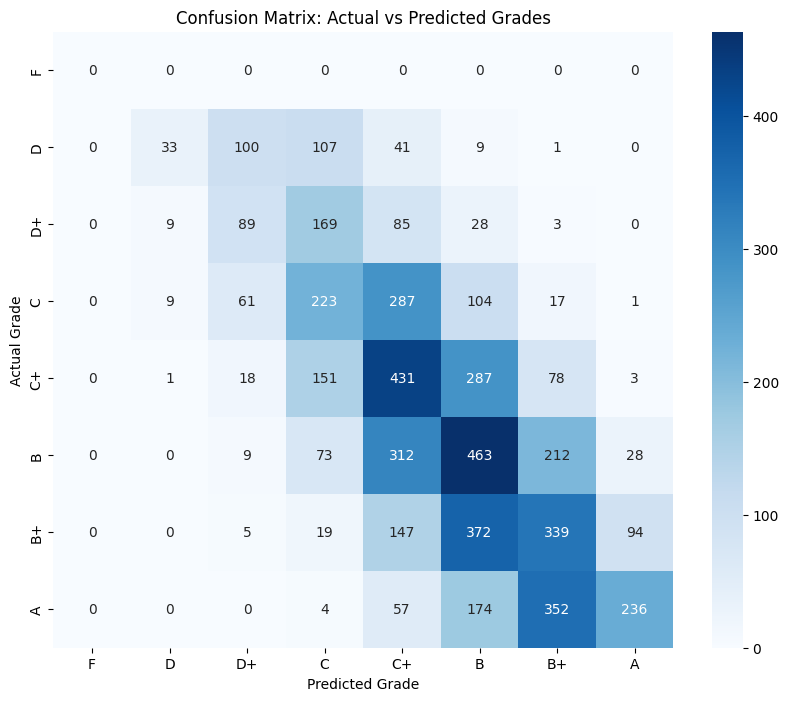


--- Detailed Classification Report ---
              precision    recall  f1-score   support

           F       0.00      0.00      0.00         0
           D       0.63      0.11      0.19       291
          D+       0.32      0.23      0.27       383
           C       0.30      0.32      0.31       702
          C+       0.32      0.44      0.37       969
           B       0.32      0.42      0.37      1097
          B+       0.34      0.35      0.34       976
           A       0.65      0.29      0.40       823

    accuracy                           0.35      5241
   macro avg       0.36      0.27      0.28      5241
weighted avg       0.39      0.35      0.34      5241



In [8]:
# 1. Define Mapping: Score -> Letter
# ต้องเรียงลำดับจากน้อยไปมาก เพื่อให้ Matrix สวยงาม
score_to_letter = {
    0.0: 'F', 1.0: 'D', 1.5: 'D+', 2.0: 'C', 2.5: 'C+',
    3.0: 'B', 3.5: 'B+', 4.0: 'A'
}

# สร้าง list ของเกรดที่เป็นไปได้ (เอาไว้ระบุ Labels)
# กรองเอาเฉพาะที่มีใน map (เผื่อกรณีข้อมูลไม่มี F)
valid_scores = sorted(score_to_letter.keys())
valid_labels = [score_to_letter[s] for s in valid_scores]

# 2. Helper function: หาเกรดที่ใกล้ที่สุด
def get_nearest_grade_key(pred_score):
    # หา key (คะแนน) ที่ใกล้ที่สุด
    return min(valid_scores, key=lambda x: abs(x - pred_score))

# 3. Prepare Data
y_true_letters = []
y_pred_letters = []

for pred in pred_user:
    # 3.1 แปลง Actual Grade (r_ui) เป็น Letter
    # ใช้ get_nearest_grade_key เผื่อค่า r_ui มีทศนิยมเพี้ยนเล็กน้อย
    true_score_key = get_nearest_grade_key(pred.r_ui)
    y_true_letters.append(score_to_letter[true_score_key])

    # 3.2 แปลง Predicted Grade (est) เป็น Letter
    pred_score_key = get_nearest_grade_key(pred.est)
    y_pred_letters.append(score_to_letter[pred_score_key])

# 4. Generate Confusion Matrix
# สำคัญ: ต้องใส่ labels=valid_labels เพื่อบังคับลำดับ (D -> A)
cm = confusion_matrix(y_true_letters, y_pred_letters, labels=valid_labels)

# 5. Plot Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=valid_labels,
            yticklabels=valid_labels)

plt.title('Confusion Matrix: Actual vs Predicted Grades')
plt.xlabel('Predicted Grade')
plt.ylabel('Actual Grade')
plt.show()

# 6. Classification Report
print("\n--- Detailed Classification Report ---")
print(classification_report(y_true_letters, y_pred_letters, target_names=valid_labels, zero_division=0,labels=valid_labels))

## 6.Confusion Matrix 5 grades


--- 5-Grade Classification Report ---
              precision    recall  f1-score   support

           F       0.00      0.00      0.00         0
           D       0.69      0.34      0.46       674
           C       0.52      0.65      0.58      1671
           B       0.57      0.67      0.61      2073
           A       0.65      0.29      0.40       823

    accuracy                           0.56      5241
   macro avg       0.49      0.39      0.41      5241
weighted avg       0.58      0.56      0.55      5241



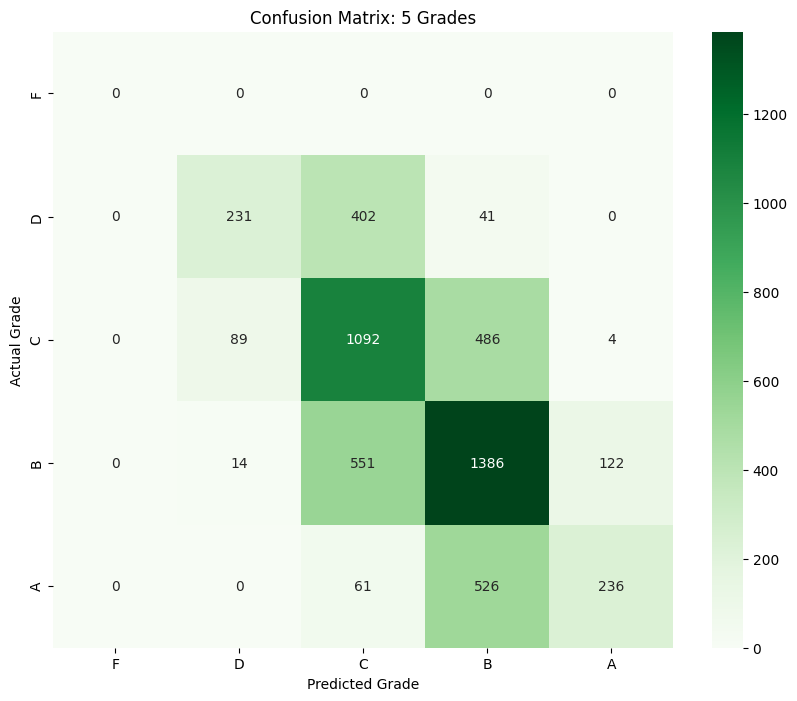

In [9]:
# Mapping: 5 Grades (Collapsing Plus grades)
score_to_letter_5 = {
    0.0: 'F', 
    1.0: 'D', 1.5: 'D', 
    2.0: 'C', 2.5: 'C',
    3.0: 'B', 3.5: 'B', 
    4.0: 'A'
}
valid_labels_5 = ['F', 'D', 'C', 'B', 'A']
# We still check against the full range of possible scores
valid_scores_all = [0.0, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]

y_true_5 = [score_to_letter_5[get_nearest_grade_key(p.r_ui)] for p in pred_user]
y_pred_5 = [score_to_letter_5[get_nearest_grade_key(p.est)] for p in pred_user]

# Plot Heatmap 5 Grades
plt.figure(figsize=(10, 8))
cm_5 = confusion_matrix(y_true_5, y_pred_5, labels=valid_labels_5)
sns.heatmap(cm_5, annot=True, fmt='d', cmap='Greens', xticklabels=valid_labels_5, yticklabels=valid_labels_5)
plt.title('Confusion Matrix: 5 Grades')
plt.xlabel('Predicted Grade')
plt.ylabel('Actual Grade')

print("\n--- 5-Grade Classification Report ---")
print(classification_report(y_true_5, y_pred_5, target_names=valid_labels_5, labels=valid_labels_5, zero_division=0))

## R2 Score

In [10]:
y_true_raw = [pred.r_ui for pred in pred_user]
y_pred_raw = [pred.est for pred in pred_user]

y_pred_rounded = [np.round(pred.est * 2) / 2 for pred in pred_user]

# 2. คำนวณ R2 Score
r2 = r2_score(y_true_raw, y_pred_raw)
r2Rounded = r2_score(y_true_raw, y_pred_rounded)


print(f"R2 Score: {r2:.4f}")
print(f"R2 Score Rounded: {r2Rounded:.4f}")

R2 Score: 0.5350
R2 Score Rounded: 0.5011
